<a href="https://colab.research.google.com/github/tinapiao/Fruit-Image-Classification/blob/main/Data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
import torchvision.transforms as transforms

In [ ]:
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            #print(label_index)
            indices.append(i)
    return indices

In [ ]:
def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('beaver', 'dolphin', 'otter', 'seal', 'whale', 
           'aquarium fish', 'flatfish', 'ray', 'shark', 'trout',
           'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', 
           'bottles', 'bowls', 'cans', 'cups', 'plates', 'apples',
           'mushrooms', 'oranges', 'pears', 'sweet peppers', 
           'clock', 'computer keyboard', 'lamp', 'telephone', 
           'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 
           'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 
           'bear', 'leopard', 'lion', 'tiger', 'wolf',	'bridge', 
           'castle', 'house', 'road', 'skyscraper', 'cloud', 'forest',
           'mountain', 'plain', 'sea',	'camel', 'cattle', 'chimpanzee',
           'elephant', 'kangaroo',	'fox', 'porcupine', 'possum', 
           'raccoon', 'skunk', 'crab', 'lobster', 'snail', 
           'spider', 'worm', 'baby', 'boy', 'girl', 'man', 
           'woman', 'crocodile', 'dinosaur', 'lizard', 'snake', 
           'turtle', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 
           'maple', 'oak', 'palm', 'pine', 'willow', 'bicycle', 
           'bus', 'motorcycle', 'pickup truck', 'train', 
           'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor')
    classes = sorted(classes)
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.1) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler) #
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler) #
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

In [ ]:
# This will download the CIFAR-100 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=['apples'], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


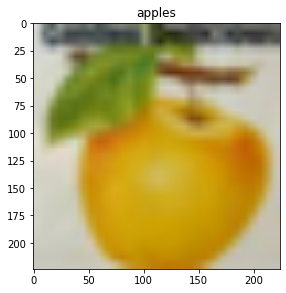

In [ ]:
from PIL import Image
classes = ('beaver', 'dolphin', 'otter', 'seal', 'whale', 
           'aquarium fish', 'flatfish', 'ray', 'shark', 'trout',
           'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', 
           'bottles', 'bowls', 'cans', 'cups', 'plates', 'apples',
           'mushrooms', 'oranges', 'pears', 'sweet peppers', 
           'clock', 'computer keyboard', 'lamp', 'telephone', 
           'television', 'bed', 'chair', 'couch', 'table', 'wardrobe', 
           'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach', 
           'bear', 'leopard', 'lion', 'tiger', 'wolf',	'bridge', 
           'castle', 'house', 'road', 'skyscraper', 'cloud', 'forest',
           'mountain', 'plain', 'sea',	'camel', 'cattle', 'chimpanzee',
           'elephant', 'kangaroo',	'fox', 'porcupine', 'possum', 
           'raccoon', 'skunk', 'crab', 'lobster', 'snail', 
           'spider', 'worm', 'baby', 'boy', 'girl', 'man', 
           'woman', 'crocodile', 'dinosaur', 'lizard', 'snake', 
           'turtle', 'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel', 
           'maple', 'oak', 'palm', 'pine', 'willow', 'bicycle', 
           'bus', 'motorcycle', 'pickup truck', 'train', 
           'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor')
classes = sorted(classes)

import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]

    #image.save()
    #Mount google drive
    #use !ls
    #!cd bla/googleDrive/
    # imgnp= Image.fromarray(image.numpy())
    # imgnp.save('images/oranges/img00'+k+'.png')
    #set random seed for repeat
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])

    # imgnp= Image.fromarray(img[0].numpy())
    # if imgnp != 'RGB':
    #     imgnp = imgnp.convert('RGB')
    # imgnp.save('new.jpg')
    #print(img.shape)
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    ax = plt.subplot(1, 3, k+1)
    
    #plt.axis('off')
    plt.imshow(img)
    ax.set_title(classes[labels[0].numpy()])

    k += 1
    if k > 0:
        break

In [ ]:
#Due the resulting blurry images this dataset was not used 

Loading Fruit 360

In [ ]:
import PIL
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 15

def show_dataset(dataset, n=5):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(4052,4053)))
  plt.imshow(img)
  plt.axis('off')

In [ ]:
torch.manual_seed(1000)
transform = transforms.Compose([
    transforms.Resize((224,224)),transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3, fill=0),
     transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_na = transforms.Compose([
     transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
dataset = torchvision.datasets.ImageFolder('/content/gdrive/My Drive/Colab Notebooks/test images', transform= transform_na)
#dataset before data augmentation

Apple Crimson Snow


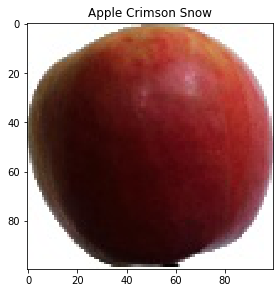

In [ ]:
# displaying a sample image before data augmentation
classes = ("Apple Crimson Snow","no other")
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                               num_workers=1)
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    img = np.transpose(image, [1,2,0])
    img = img / 2 + 0.5
    ax = plt.subplot(1, 3, k+1)
    
    #plt.axis('off')
    plt.imshow(img)
    ax.set_title(classes[labels[0].numpy()])

    k += 1
    if k > 0:
      break

In [ ]:
dataset_transformed = torchvision.datasets.ImageFolder('/content/gdrive/My Drive/Colab Notebooks/test images', transform= transform)

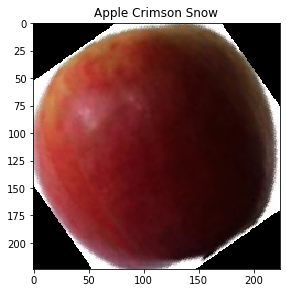

In [ ]:
# displaying a sample image after data augmentation
classes = ('Apple Crimson Snow', 'No other')
train_loader = torch.utils.data.DataLoader(dataset_transformed, batch_size=1,
                                               num_workers=1)
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    img = np.transpose(image, [1,2,0])
    img = img / 2 + 0.5
    ax = plt.subplot(1, 3, k+1)
    
    #plt.axis('off')
    plt.imshow(img)
    ax.set_title(classes[labels[0].numpy()])

    k += 1
    if k > 0:
        break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


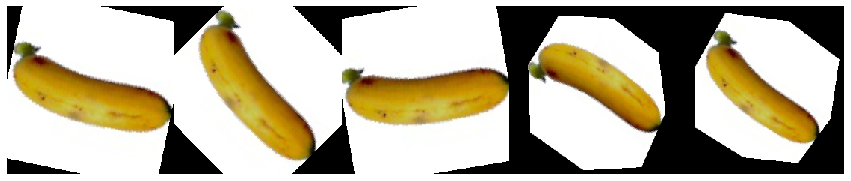

In [ ]:
show_dataset(dataset_transformed)

In [ ]:
show_dataset(dataset)

Steps:
* Download Fruit360 & CIFAR100
* CIFAR 100 eliminated due to low resolution impact that results in very blurry images when resized
* Fruit360 processing:
  * Resizing to 244x244
  * Data augmentation:
    * Flip horizontally and vertically(simulate fruit random placement)
    * Rotate images at 90 degree(simulate fruit random placement)
    * Modify perspective (simulate different camera locations)

* Collect additional testing images 20 (no need for crosschecking)
* Clean and label them
* Create the folder and upload
* To remove data imbalance add augmented data else just augment but no copying data(see tut3b)



In [ ]:
#visualize test data
def get_accuracy(model, train=False):
    if train:
        data_loader = train_loader
    else:
        data_loader = val_loader

    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
         
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        
        output = model(ALNC(imgs))
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        ---------------------------------------------------------------------
        # obtain one batch of training images
        dataiter = iter(train_loader)
        images, labels = dataiter.next()
        images = images.numpy() # convert images to numpy for display

        # plot the images in the batch, along with the corresponding labels
        fig = plt.figure(figsize=(25, 4))
        for idx in np.arange(20):
            ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
            plt.imshow(np.transpose(images[idx], (1, 2, 0)))
            ax.set_title(classes[labels[idx]])
        ---------------------------------------------------------------------
        total += imgs.shape[0]
    return correct / total


In [ ]:
#show images with label predicted
#show classes with their guess distribution


In [ ]:
# location on Google Drive
master_path = '/content/gdrive/My Drive/Colab Notebooks/Project data processing/fruits-360/Training'
# applying transformations to simulate the checkout environment at the grocery store
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision

# Transform Settings - Do not use RandomResizedCrop
transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomRotation(90),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomPerspective(distortion_scale=0.3, p=0.5, interpolation=3, fill=0),
                                transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder(master_path, transform=transform)
train_size = int(0.6 * (len(dataset)))

In [ ]:
batch_size = 27
num_workers = 1

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=False)

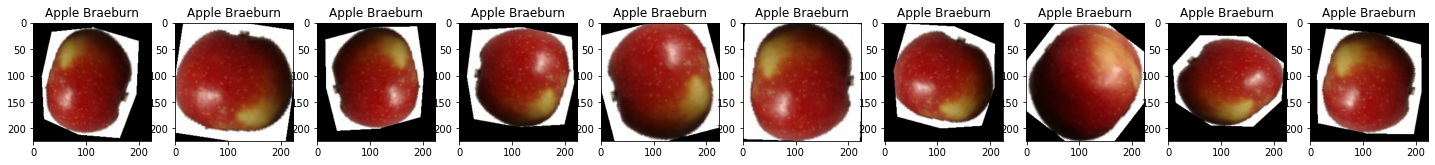

In [ ]:
# Prepare Dataloader



# Visualize some sample data
classes = ['Apple Braeburn', 'Apple Golden 2', 'Apple Granny Smith', 
            'Apple Red 1', 'Apple Red 2', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 
            'Apricot', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 
            'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 
            'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Fig', 
            'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 
            'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kumquats', 
            'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 
            'Mulberry', 'Nectarine', 'Nut Forest', 'Nut Pecan', 'Papaya', 'Passion Fruit', 'Peach', 
            'Peach 2', 'Peach Flat', 'Pear', 'Pear 2', 'Pear Abate', 'Pear Forelle', 
            'Pear Monster', 'Pear Red', 'Pear Stone', 'Pear Williams', 'Pepino', 'Pepper Orange', 'Pepper Red', 'Pepper Yellow', 
            'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum 3', 'Pomegranate', 
            'Quince', 'Rambutan', 'Raspberry', 
            'Redcurrant', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 2', 'Tomato 3', 
            'Tomato Cherry Red', 'Tomato Heart', 'Walnut']

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images, labels = dataiter.next()
images, labels = dataiter.next()
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(1, 10, idx+1)
    plt.imshow(np.transpose(images[(idx)], (1, 2, 0)))
    ax.set_title(classes[labels[(idx)]])